<a href="https://colab.research.google.com/github/keijiyo/Study_AI_recipe_book/blob/main/AI_Recipe_Part6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 6　Eコマースデータ×協調フィルタリング分析モデル

##introduction
商品レコメンドエンジンを構築したい

レコメンドエンジンを構築する手法には、大きく分けて「内容ベース」と「協調フィルタリング」という2つがある。

今回は協調フィルタリングを用いる

In [ ]:
#Part 6

##レシピ6.1　データの準備

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


購入情報データ　読込・表示

In [5]:
import pandas as pd

List_of_Orders = pd.read_csv('drive/My Drive/ai_recipe/List of Orders.csv')
List_of_Orders.head()

,Order ID,Order Date,CustomerName,State,City
0,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad
1,B-25602,01-04-2018,Pearl,Maharashtra,Pune
2,B-25603,03-04-2018,Jahan,Madhya Pradesh,Bhopal
3,B-25604,03-04-2018,Divsha,Rajasthan,Jaipur
4,B-25605,05-04-2018,Kasheen,West Bengal,Kolkata


注文詳細データ　読込・表示

In [7]:
Order_Details = pd.read_csv('drive/My Drive/ai_recipe/Order Details.csv')
Order_Details.head()

,Order ID,Amount,Profit,Quantity,Category,Sub-Category
0,B-25601,1275.0,-1148.0,7,Furniture,Bookcases
1,B-25601,66.0,-12.0,5,Clothing,Stole
2,B-25601,8.0,-2.0,3,Clothing,Hankerchief
3,B-25601,80.0,-56.0,4,Electronics,Electronic Games
4,B-25602,168.0,-111.0,2,Electronics,Phones


販売目標データ　読込・表示

In [8]:
Sales_target = pd.read_csv('drive/My Drive/ai_recipe/Sales target.csv')
Sales_target.head()

,Month of Order Date,Category,Target
0,Apr-18,Furniture,10400.0
1,May-18,Furniture,10500.0
2,Jun-18,Furniture,10600.0
3,Jul-18,Furniture,10800.0
4,Aug-18,Furniture,10900.0


基礎統計量の表示

In [9]:
### print つけていただく

print(List_of_Orders.describe().T)
print(Order_Details.describe().T)

             count unique             top freq
Order ID       500    500         B-25601    1
Order Date     500    307      24-11-2018    7
CustomerName   500    332          Shreya    6
State          500     19  Madhya Pradesh  101
City           500     24          Indore   76
           count        mean         std     min    25%    50%    75%     max
Amount    1500.0  287.668000  461.050488     4.0  45.00  118.0  322.0  5729.0
Profit    1500.0   15.970000  169.140565 -1981.0  -9.25    9.0   38.0  1698.0
Quantity  1500.0    3.743333    2.184942     1.0   2.00    3.0    5.0    14.0


データの結合  
indicator=Trueで_merge列が追加される。欠損値チェックに使える

In [10]:
mst_data = pd.merge(List_of_Orders, Order_Details,
                    on='Order ID', how='outer', indicator=True)
mst_data.head()

,Order ID,Order Date,CustomerName,State,City,Amount,Profit,Quantity,Category,Sub-Category,_merge
0,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad,1275.0,-1148.0,7.0,Furniture,Bookcases,both
1,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad,66.0,-12.0,5.0,Clothing,Stole,both
2,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad,8.0,-2.0,3.0,Clothing,Hankerchief,both
3,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad,80.0,-56.0,4.0,Electronics,Electronic Games,both
4,B-25602,01-04-2018,Pearl,Maharashtra,Pune,168.0,-111.0,2.0,Electronics,Phones,both


データの欠損確認

In [11]:
mst_data['_merge'].value_counts()

both          1500
left_only       60
right_only       0
Name: _merge, dtype: int64

欠損データの削除  
片方だけのデータはdrop（how='inner'と同じ）

In [12]:
mst_data.drop(mst_data.loc[mst_data['_merge'] != 'both'].index, inplace=True)

箱ひげ図の出力

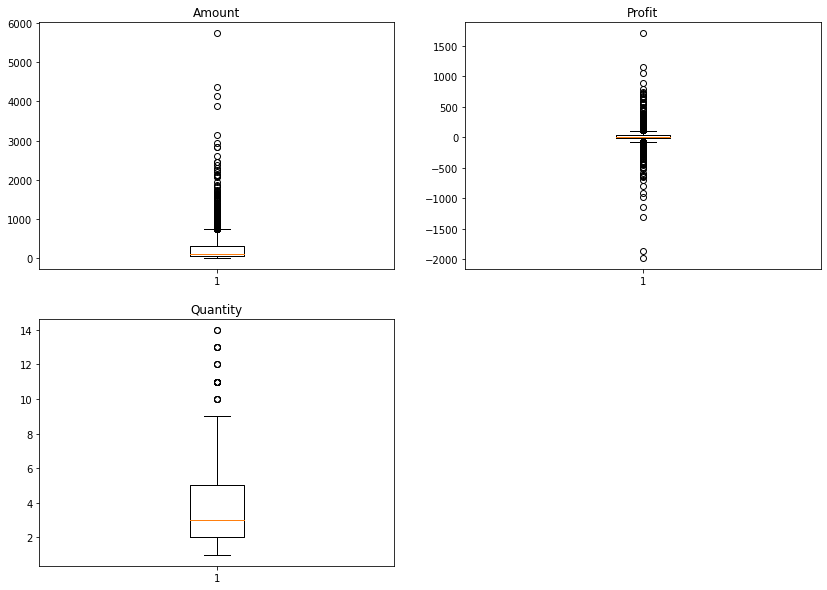

In [14]:
#箱ひげ図の作成

#numpy,matplotの呼び出し
import numpy as np
import matplotlib.pyplot as plt

#必要項目
mst_data_a = mst_data[['Amount', 'Profit', 'Quantity']]

#プロットエリアの指定
fig = plt.figure(figsize=(14, 10))

#グラフの出力
for i in np.arange((mst_data_a.shape[1])):
    plt.subplot(2,2,i+1)
    plt.boxplot(mst_data_a.dropna().iloc[:,i])
    plt.title(mst_data_a.columns[i])

ヒストグラムの出力

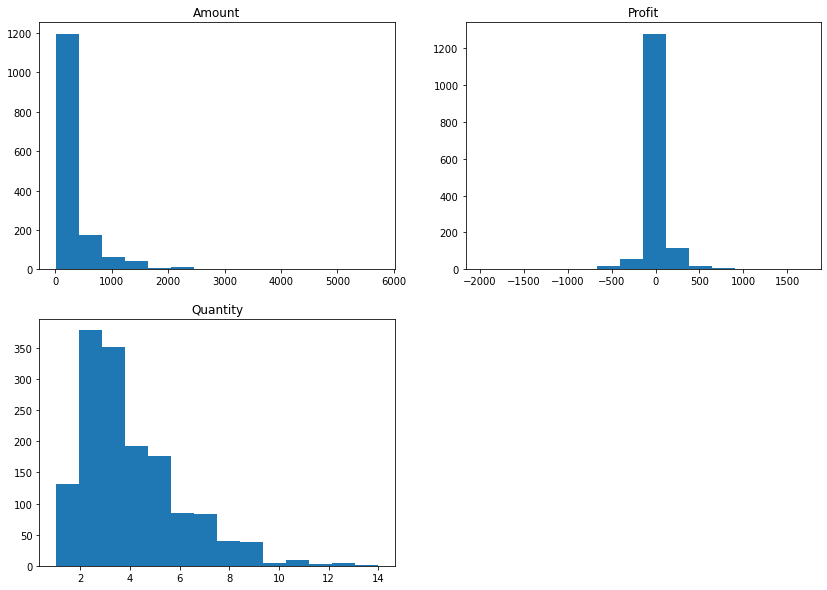

In [15]:
#プロットエリアの指定
fig = plt.figure(figsize=(14, 10))

#グラフの出力
for i in np.arange((mst_data_a.shape[1])):
    plt.subplot(2,2,i+1)
    plt.hist(mst_data_a.dropna().iloc[:,i], bins=14)
    plt.title(mst_data_a.columns[i])

変数分布の出力

In [16]:
#必要項目
mst_data_b = mst_data[['State', 'City', 'Category', 'Sub-Category']]

#件数・構成比の出力
for i in np.arange((mst_data_b.shape[1])):
    print(mst_data_b.dropna().iloc[:,i].value_counts().sort_index())
    print(mst_data_b.dropna().iloc[:,i].value_counts(normalize=True).sort_index())

Andhra Pradesh        42
Bihar                 62
Delhi                 74
Goa                   43
Gujarat               87
Haryana               26
Himachal Pradesh      29
Jammu and Kashmir     49
Karnataka             54
Kerala                45
Madhya Pradesh       340
Maharashtra          290
Nagaland              45
Punjab                60
Rajasthan             74
Sikkim                24
Tamil Nadu            25
Uttar Pradesh         68
West Bengal           63
Name: State, dtype: int64
Andhra Pradesh       0.028000
Bihar                0.041333
Delhi                0.049333
Goa                  0.028667
Gujarat              0.058000
Haryana              0.017333
Himachal Pradesh     0.019333
Jammu and Kashmir    0.032667
Karnataka            0.036000
Kerala               0.030000
Madhya Pradesh       0.226667
Maharashtra          0.193333
Nagaland             0.030000
Punjab               0.040000
Rajasthan            0.049333
Sikkim               0.016000
Tamil Nadu         

##レシピ6.2　商品間の相関分析

相関係数を行列を算出する

買った場合は1、買わない場合は0がセットされる

In [18]:
# mst_data →　レシピ6.1で作成したマスターデータ

mst_data.loc[mst_data['Quantity'] > 0, 'Quantity'] = 1
mst_data_cs = mst_data.pivot_table(index = ['CustomerName'],
                                   columns=['Sub-Category'],
                                   values='Quantity').fillna(0)
mst_data_cs.head()

Sub-Category,Accessories,Bookcases,Chairs,Electronic Games,Furnishings,Hankerchief,Kurti,Leggings,Phones,Printers,Saree,Shirt,Skirt,Stole,T-shirt,Tables,Trousers
CustomerName,,,,,,,,,,,,,,,,,
Aakanksha,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Aarushi,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
Aashna,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
Aastha,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
Aayush,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


相関係数行列の算出

In [19]:
# 相関係数行列
# methodはピアソンの相関係数を指定

corr = mst_data_cs.corr(method='pearson')
corr.head()

Sub-Category,Accessories,Bookcases,Chairs,Electronic Games,Furnishings,Hankerchief,Kurti,Leggings,Phones,Printers,Saree,Shirt,Skirt,Stole,T-shirt,Tables,Trousers
Sub-Category,,,,,,,,,,,,,,,,,
Accessories,1.000000,0.130166,0.008607,0.107825,0.052193,0.203946,0.057543,0.101181,0.207752,0.100577,0.177947,0.141003,0.089955,0.090333,0.087981,0.086274,0.107293
Bookcases,0.130166,1.000000,0.149310,0.092549,0.097006,0.087570,0.010001,0.093635,0.093806,0.279564,0.199454,0.086841,0.059453,0.140939,0.168230,0.033336,0.057436
Chairs,0.008607,0.149310,1.000000,0.032183,0.036131,0.080573,-0.076009,-0.023223,-0.020972,0.083617,0.149538,0.162483,0.136355,0.000186,0.070896,0.114274,0.166635
Electronic Games,0.107825,0.092549,0.032183,1.000000,0.075077,0.176109,-0.003216,0.108197,0.111469,0.182200,0.149538,0.103334,-0.008475,0.154806,0.090252,0.040749,0.069577
Furnishings,0.052193,0.097006,0.036131,0.075077,1.000000,0.150875,-0.000515,0.089934,0.020869,0.147272,0.093263,0.067930,0.098933,0.115634,0.075077,0.079650,0.023896


相関係数行列をヒートマップで表示

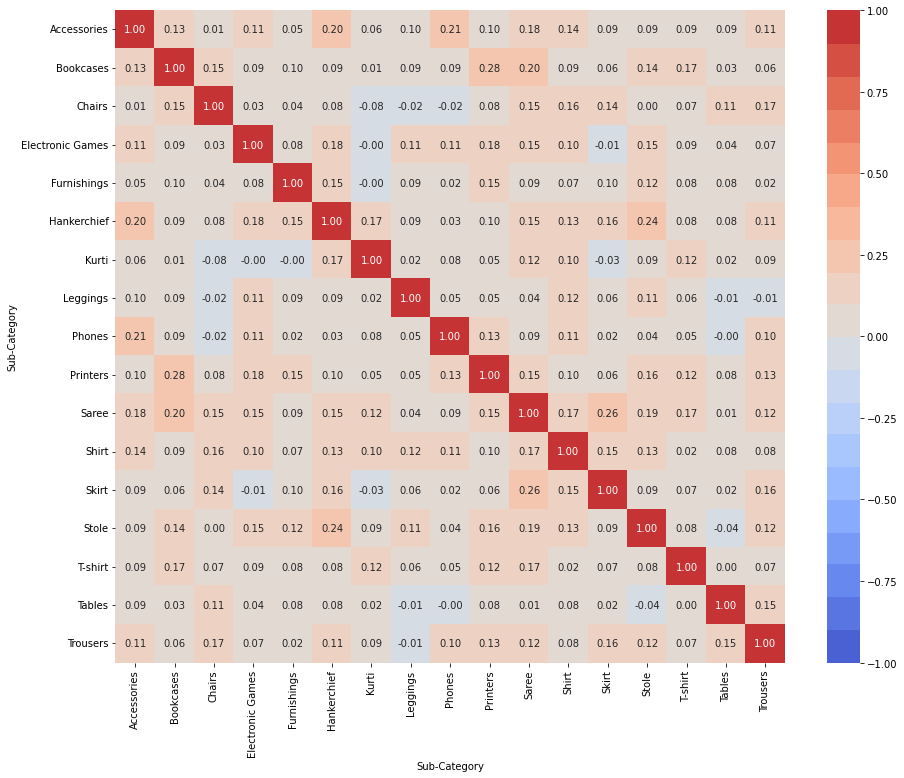

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
sns.heatmap(corr, vmin=-1, vmax=1, 
            cmap= sns.color_palette('coolwarm', 20),
            center=0 , annot=True, fmt='.2f')

##レシピ6.3　協調フィルタリング

レコメンドエンジンを構築する

商品の推薦度を出力する

マスタデータの並べ替え

pandasのmeltは横持ちを縦持ちに直すイメージ。  

value列名は指定可能（デフォルト：'value'）

In [21]:
mst_data_cs2 = mst_data_cs.reset_index().melt(id_vars=['CustomerName']) 
mst_data_cs2

,CustomerName,Sub-Category,value
0,Aakanksha,Accessories,0.0
1,Aarushi,Accessories,1.0
2,Aashna,Accessories,1.0
3,Aastha,Accessories,1.0
4,Aayush,Accessories,0.0
...,...,...,...
5639,Wale,Trousers,0.0
5640,Yaanvi,Trousers,0.0
5641,Yash,Trousers,0.0
5642,Yogesh,Trousers,0.0


データの取り出し  
最初の5レコードを予測に使うため

In [22]:
mst_data_cs3 = mst_data_cs2.drop(range(0, 5))
mst_data_cs3

,CustomerName,Sub-Category,value
5,Aayushi,Accessories,0.0
6,Abhijeet,Accessories,0.0
7,Abhijit,Accessories,0.0
8,Abhishek,Accessories,1.0
9,Adhvaita,Accessories,0.0
...,...,...,...
5639,Wale,Trousers,0.0
5640,Yaanvi,Trousers,0.0
5641,Yash,Trousers,0.0
5642,Yogesh,Trousers,0.0


http://surpriselib.com/  
推奨システムのためのパッケージ

データセットクラスへ返還

In [23]:
!pip install surprise #installつける

from surprise import Reader, Dataset

reader = Reader(line_format='user item rating',
                sep=' ', rating_scale=(0, 1))
mst_data_knn2 = Dataset.load_from_df(mst_data_cs3, reader)
train = mst_data_knn2.build_full_trainset()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 15.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633994 sha256=779cafd098cf5b8270152bb0bc1dfb4be4b27528bd6a1cb203aa1094616d25ea
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


KNNBasicモジュールへのデータ投入

コサイン類似度を使用
$$ \cos \theta = \frac{\sum_{i=1}^{n}(x_i) \times (y_i)}{\sqrt{\sum_{i=1}^{n}(x_i)^2} \sqrt{\sum_{i=1}^{n}(y_i)^2}} $$

In [24]:
from surprise import KNNBasic

algo = KNNBasic(k=3, min_k=1,
                sim_options={'name': 'cosine', 'user_based': True})
algo.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


/usr/local/lib/python3.7/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


購買有無の予測

In [25]:
prediction = algo.predict(uid='Aakanksha', iid='Accessories')
print('CustomerName: {0}, Sub-Category: {1}, {2:.3f}'
        .format(prediction.uid, prediction.iid, prediction.est))

prediction = algo.predict(uid='Aarushi', iid='Accessories')
print('CustomerName: {0}, Sub-Category: {1}, {2:.3f}'
        .format(prediction.uid, prediction.iid, prediction.est))

prediction = algo.predict(uid='Aashna', iid='Accessories')
print('CustomerName: {0}, Sub-Category: {1}, {2:.3f}'
        .format(prediction.uid, prediction.iid, prediction.est))

prediction = algo.predict(uid='Aastha', iid='Accessories')
print('CustomerName: {0}, Sub-Category: {1}, {2:.3f}'
        .format(prediction.uid, prediction.iid, prediction.est))

prediction = algo.predict(uid='Aayush', iid='Accessories')
print('CustomerName: {0}, Sub-Category: {1}, {2:.3f}'
        .format(prediction.uid, prediction.iid, prediction.est))

CustomerName: Aakanksha, Sub-Category: Accessories, 0.000
CustomerName: Aarushi, Sub-Category: Accessories, 0.330
CustomerName: Aashna, Sub-Category: Accessories, 0.667
CustomerName: Aastha, Sub-Category: Accessories, 0.336
CustomerName: Aayush, Sub-Category: Accessories, 0.000


ユーザーベースの協調フィルタリング

ピアソンの相関係数を使用

$$ r = \frac{\sum_{i=1}^{n}(x_i -x ) \times (y_i - y)}{\sqrt{\sum_{i=1}^{n}(x_i - x)^2} \sqrt{\sum_{i=1}^{n}(y_i - y)^2}} $$

In [26]:
from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate

reader = Reader(line_format='user item rating',
                sep=' ', rating_scale=(0, 1))
mst_data_knn3 = Dataset.load_from_df(mst_data_cs2, reader)

algo = KNNBasic(k=10, min_k=1,
                sim_options={'name': 'pearson', 'user_based': True})
kfold = KFold(n_splits=5, random_state=123)
perf = cross_validate(algo, mst_data_knn3, measures=['RMSE'],
                      cv=kfold, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4032  0.3940  0.4050  0.3880  0.3944  0.3969  0.0063  
Fit time          0.12    0.12    0.12    0.12    0.12    0.12    0.00    
Test time         0.17    0.17    0.19    0.17    0.18    0.18    0.01    


アイテムベースの協調フィルタリング

In [27]:
from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate

reader = Reader(line_format='user item rating',
                sep=' ', rating_scale=(0, 1))
mst_data_knn3 = Dataset.load_from_df(mst_data_cs2, reader)

algo = KNNBasic(k=10, min_k=1,
                sim_options={'name': 'pearson', 'user_based': False})
kfold = KFold(n_splits=5, random_state=123)
perf = cross_validate(algo, mst_data_knn3, measures=['RMSE'],
                      cv=kfold, verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4039  0.4101  0.4253  0.3988  0.4107  0.4098  0.0089  
Fit time          0.00    0.00    0.00    0.01    0.00    0.00    0.00    
Test time         0.03    0.05    0.03    0.03    0.03    0.03    0.01    


特異値分解の実行

In [28]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate

reader = Reader(line_format='user item rating',
                sep=' ', rating_scale=(0, 1))
mst_data_knn3 = Dataset.load_from_df(mst_data_cs2, reader)

algo = SVD(n_factors=30, n_epochs=50, biased=True,
           lr_all=0.005, reg_all=0.3)
kfold = KFold(n_splits=5, random_state=123)
perf = cross_validate(algo, mst_data_knn3, measures=['RMSE'],
                      cv=kfold, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3856  0.3804  0.3920  0.3733  0.3820  0.3827  0.0061  
Fit time          0.28    0.31    0.30    0.29    0.28    0.29    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


今回は以下の順で精度が良いという結果となった（RMSEが小さい順）

1. 特異値分解
2. ユーザーベースの協調フィルタリング
3. アイテムベースの協調フィルタリング